In [1]:
# =============================================
# CELL 1: Import all required libraries
# =============================================

# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Date Handling
from datetime import datetime, timedelta
import calendar

# Warnings ignore karo
import warnings
warnings.filterwarnings('ignore')

# Style settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
sns.set_style("whitegrid")

print(f"✅ Pandas version: {pd.__version__}")
print(f"✅ NumPy version: {np.__version__}")
print(f"✅ Matplotlib version: {plt.matplotlib.__version__}")
print(f"✅ Seaborn version: {sns.__version__}")

✅ Pandas version: 2.2.2
✅ NumPy version: 1.26.4
✅ Matplotlib version: 3.9.2
✅ Seaborn version: 0.13.2


In [6]:
# =============================================
# CELL 2: Load all CSV files
# =============================================

print("📂 Loading CSV files...")

# Load all data
df_medicines = pd.read_csv('medicines_master.csv')
df_purchases = pd.read_csv('purchases_transactions.csv')
df_reorder = pd.read_csv('reorder_levels.csv')
df_sales = pd.read_csv('C:sales_transactions.csv')
df_suppliers = pd.read_csv('C:suppliers_master.csv')



📂 Loading CSV files...


In [7]:
df_medicines

medicine_id              medicine_name   category   therapeutic_class  \
0          1000          Paracetamol 500mg     Tablet             Hormone   
1          1001          Paracetamol 650mg     Tablet    Antihypertensive   
2          1002          Amoxicillin 250mg     Tablet               NSAID   
3          1003          Amoxicillin 500mg     Tablet        Antimalarial   
4          1004         Azithromycin 500mg     Tablet          Antibiotic   
5          1005            Cetirizine 10mg     Tablet        Antidiabetic   
6          1006            Omeprazole 20mg     Tablet        Antimalarial   
7          1007            Metformin 500mg     Tablet               NSAID   
8          1008           Metformin 1000mg     Tablet          Antifungal   
9          1009             Amlodipine 5mg     Tablet          Antibiotic   
10         1010          Atorvastatin 10mg     Tablet         Antipyretic   
11         1011          Atorvastatin 20mg     Tablet         Antipyretic   
12         1012                Cough Syrup      Syrup           Analgesic   
13         1013                    Antacid      Syrup  Vitamin Supplement   
14         1014          Paracetamol Syrup      Syrup               NSAID   
15         1015            Ibuprofen Syrup      Syrup                 PPI   
16         1016           Cetirizine Syrup      Syrup             Hormone   
17         1017              Insulin Rapid  Injection         Antipyretic   
18         1018        Insulin Long-acting  Injection             Hormone   
19         1019      Pain Killer Injection  Injection        Antidiabetic   
20         1020       Antibiotic Injection  Injection         Antipyretic   
21         1021      Vitamin B12 Injection  Injection    Antihypertensive   
22         1022    Omeprazole Capsule 20mg    Capsule  Vitamin Supplement   
23         1023           Cephalexin 500mg    Capsule               NSAID   
24         1024          Doxycycline 100mg    Capsule                 PPI   
25         1025  Amoxicillin Capsule 500mg    Capsule             Hormone   
26         1026           Antifungal Cream      Cream             Hormone   
27         1027           Antibiotic Cream      Cream          Antibiotic   
28         1028            Pain Relief Gel      Cream         Antipyretic   
29         1029         Moisturizing Cream      Cream        Antidiabetic   

   manufacturer package_size  unit_type  is_emergency  is_refrigerated  \
0         Cipla     10 units     Tablet             1                0   
1        Abbott     15 units     Tablet             0                0   
2         Cipla     10 units     Tablet             0                0   
3         Cipla     10 units     Tablet             0                0   
4    Sun Pharma      3 units     Tablet             1                0   
5      Glenmark     10 units     Tablet             0                0   
6        Abbott     15 units     Tablet             0                0   
7      Glenmark     10 units     Tablet             0                0   
8       Torrent     10 units     Tablet             0                0   
9    Dr Reddy's     15 units     Tablet             0                0   
10       Pfizer     10 units     Tablet             1                0   
11        Cipla     10 units     Tablet             1                0   
12     Novartis       100 ml      Syrup             0                0   
13       Pfizer       200 ml      Syrup             0                0   
14        Lupin        60 ml      Syrup             0                0   
15        Cipla       100 ml      Syrup             0                0   
16      Torrent        60 ml      Syrup             0                0   
17      Torrent   10 ml vial  Injection             1                1   
18       Abbott   10 ml vial  Injection             0                0   
19        Cipla    2 ml vial  Injection             0                1   
20   Dr Reddy's    1 ml vial  Injection             0         

In [9]:
# =============================================
# CELL 3: Data Cleaning and Merging
# =============================================

print("🧹 Data Cleaning Started...")

# Check for missing values
print("\n1️⃣ Missing Values Check:")
print(df_medicines.isnull().sum())
print(df_purchases.isnull().sum())

# Merge medicines with purchases to get medicine-wise total stock
print("\n2️⃣ Calculating Medicine-wise Total Stock...")

# Group by medicine_id and sum quantity_remaining
medicine_stock = df_purchases.groupby('medicine_id').agg({
    'quantity_remaining': 'sum',
    'purchase_id': 'count',
    'purchase_price': 'mean'
}).reset_index()

medicine_stock.columns = ['medicine_id', 'total_stock', 'batch_count', 'avg_purchase_price']

# Merge with medicines master
df_medicine_stock = pd.merge(df_medicines, medicine_stock, on='medicine_id', how='left').fillna(0)

# Merge with reorder levels
df_final = pd.merge(df_medicine_stock, df_reorder, on='medicine_id', how='left')

# Calculate stock status
df_final['stock_status'] = 'IN STOCK'
df_final.loc[df_final['total_stock'] == 0, 'stock_status'] = 'OUT OF STOCK'
df_final.loc[(df_final['total_stock'] > 0) & 
             (df_final['total_stock'] < df_final['min_stock_level']), 'stock_status'] = 'LOW STOCK'

# Emergency medicines ke liye double requirement
df_final['emergency_required'] = df_final['min_stock_level'] * 2
df_final['emergency_status'] = 'OK'
df_final.loc[(df_final['is_emergency'] == 1) & 
             (df_final['total_stock'] < df_final['emergency_required']), 'emergency_status'] = 'LOW'

print(f"\n✅ Final DataFrame created with {len(df_final)} medicines")
print("\n📊 Stock Status Distribution:")
print(df_final['stock_status'].value_counts())

print("\n👀 First 5 rows:")
print(df_final[['medicine_id', 'medicine_name', 'total_stock', 'min_stock_level', 'stock_status']].head(10))

🧹 Data Cleaning Started...

1️⃣ Missing Values Check:
medicine_id          0
medicine_name        0
category             0
therapeutic_class    0
manufacturer         0
package_size         0
unit_type            0
is_emergency         0
is_refrigerated      0
created_date         0
is_active            0
dtype: int64
purchase_id           0
medicine_id           0
supplier_id           0
batch_no              0
manufacturing_date    0
expiry_date           0
quantity_purchased    0
quantity_remaining    0
purchase_price        0
selling_price         0
mrp                   0
purchase_date         0
dtype: int64

2️⃣ Calculating Medicine-wise Total Stock...

✅ Final DataFrame created with 30 medicines

📊 Stock Status Distribution:
stock_status
IN STOCK    30
Name: count, dtype: int64

👀 First 5 rows:
   medicine_id       medicine_name  total_stock  min_stock_level stock_status
0         1000   Paracetamol 500mg          590               37     IN STOCK
1         1001   Paracetamol 65

In [10]:
# =============================================
# CELL 4: Basic Statistics
# =============================================

print("📊 BASIC STATISTICS")
print("="*50)

# Overall statistics
total_medicines = len(df_final)
total_stock_units = df_final['total_stock'].sum()
avg_stock_per_medicine = df_final['total_stock'].mean()
median_stock = df_final['total_stock'].median()
max_stock = df_final['total_stock'].max()
min_stock = df_final[df_final['total_stock'] > 0]['total_stock'].min()

print(f"\n1️⃣ OVERALL METRICS:")
print(f"   Total Medicines: {total_medicines}")
print(f"   Total Stock Units: {total_stock_units:,.0f}")
print(f"   Avg Stock per Medicine: {avg_stock_per_medicine:.0f}")
print(f"   Median Stock: {median_stock:.0f}")
print(f"   Max Stock: {max_stock:,.0f}")
print(f"   Min Stock (non-zero): {min_stock}")

# Category-wise statistics
print(f"\n2️⃣ CATEGORY-WISE STATISTICS:")
category_stats = df_final.groupby('category').agg({
    'medicine_id': 'count',
    'total_stock': 'sum',
    'total_stock': 'mean'
}).round(0)
print(category_stats)

# Emergency medicines
emergency_count = df_final[df_final['is_emergency'] == 1].shape[0]
emergency_low = df_final[(df_final['is_emergency'] == 1) & 
                         (df_final['total_stock'] < df_final['min_stock_level'] * 2)].shape[0]

print(f"\n3️⃣ EMERGENCY MEDICINES:")
print(f"   Total Emergency: {emergency_count}")
print(f"   Emergency Low: {emergency_low}")

# Stock status counts
status_counts = df_final['stock_status'].value_counts()
print(f"\n4️⃣ STOCK STATUS:")
for status, count in status_counts.items():
    print(f"   {status}: {count}")

📊 BASIC STATISTICS

1️⃣ OVERALL METRICS:
   Total Medicines: 30
   Total Stock Units: 50,718
   Avg Stock per Medicine: 1691
   Median Stock: 1528
   Max Stock: 4,284
   Min Stock (non-zero): 340

2️⃣ CATEGORY-WISE STATISTICS:
           medicine_id  total_stock
category                           
Capsule              4       1550.0
Cream                4       1139.0
Injection            5       1949.0
Syrup                5       1701.0
Tablet              12       1809.0

3️⃣ EMERGENCY MEDICINES:
   Total Emergency: 7
   Emergency Low: 0

4️⃣ STOCK STATUS:
   IN STOCK: 30


📈 Creating Matplotlib Visualizations...


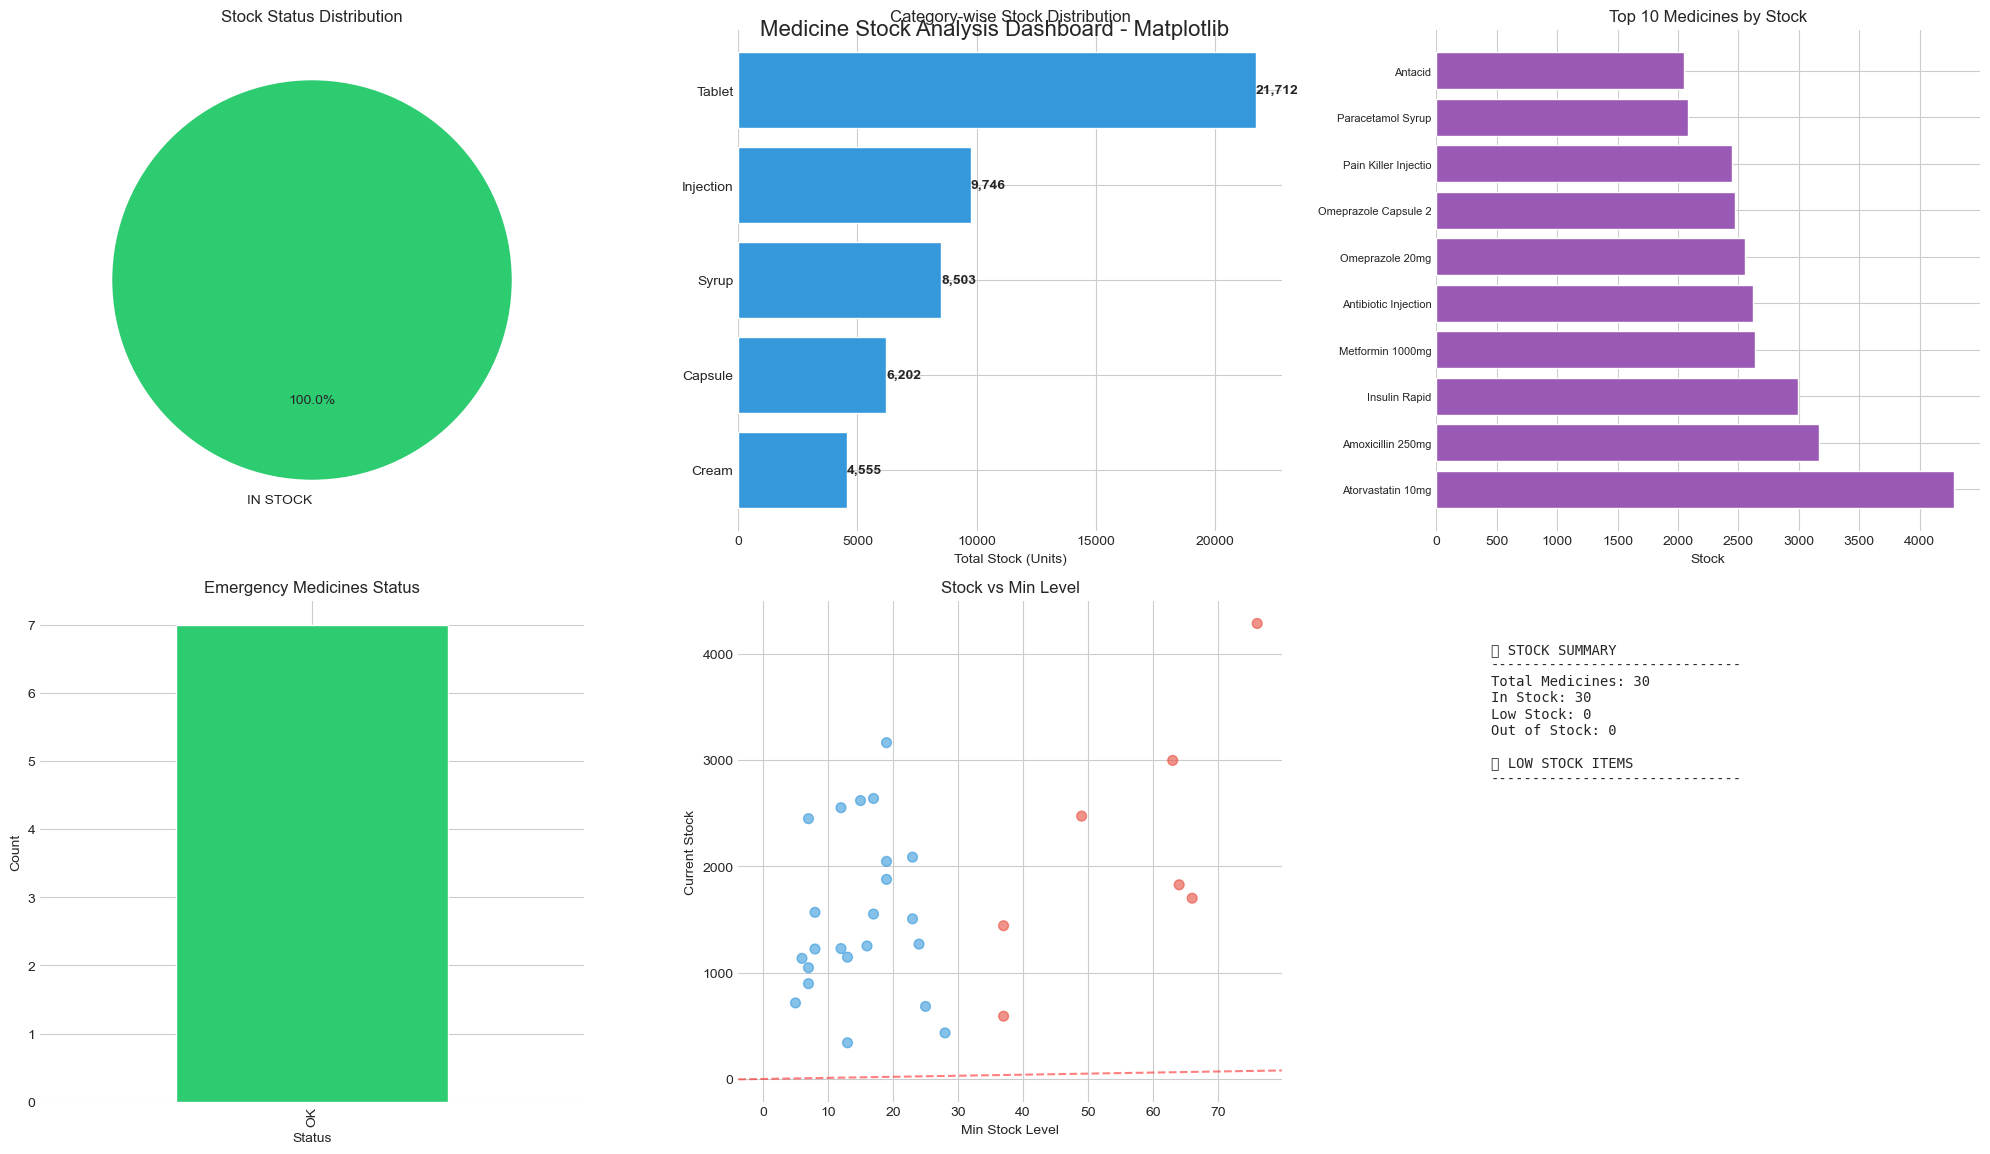

✅ Matplotlib dashboard saved as 'medicine_dashboard_matplotlib.png'


In [11]:
# =============================================
# CELL 5: Matplotlib Visualizations
# =============================================

print("📈 Creating Matplotlib Visualizations...")

# Create figure with subplots
fig = plt.figure(figsize=(20, 12))
fig.suptitle('Medicine Stock Analysis Dashboard - Matplotlib', fontsize=16, y=0.95)

# 1. Stock Status Pie Chart
ax1 = plt.subplot(2, 3, 1)
status_counts = df_final['stock_status'].value_counts()
colors = {'IN STOCK': '#2ecc71', 'LOW STOCK': '#f1c40f', 'OUT OF STOCK': '#e74c3c'}
status_colors = [colors.get(x, '#95a5a6') for x in status_counts.index]
wedges, texts, autotexts = ax1.pie(status_counts.values, 
                                    labels=status_counts.index,
                                    colors=status_colors,
                                    autopct='%1.1f%%',
                                    startangle=90)
ax1.set_title('Stock Status Distribution', fontsize=12)

# 2. Category-wise Stock Bar Chart
ax2 = plt.subplot(2, 3, 2)
category_stock = df_final.groupby('category')['total_stock'].sum().sort_values()
bars = ax2.barh(category_stock.index, category_stock.values, color='#3498db')
ax2.set_xlabel('Total Stock (Units)')
ax2.set_title('Category-wise Stock Distribution', fontsize=12)
for i, (bar, val) in enumerate(zip(bars, category_stock.values)):
    ax2.text(val, bar.get_y() + bar.get_height()/2, f'{val:,.0f}', 
             ha='left', va='center', fontweight='bold')

# 3. Top 10 Medicines by Stock
ax3 = plt.subplot(2, 3, 3)
top_10 = df_final.nlargest(10, 'total_stock')
bars = ax3.barh(top_10['medicine_name'].str[:20], top_10['total_stock'], color='#9b59b6')
ax3.set_xlabel('Stock')
ax3.set_title('Top 10 Medicines by Stock', fontsize=12)
ax3.tick_params(axis='y', labelsize=8)

# 4. Emergency Medicines Status
ax4 = plt.subplot(2, 3, 4)
emergency_data = df_final[df_final['is_emergency'] == 1]
emergency_status = emergency_data['emergency_status'].value_counts()
colors_emergency = {'OK': '#2ecc71', 'LOW': '#e74c3c'}
emergency_colors = [colors_emergency.get(x, '#95a5a6') for x in emergency_status.index]
emergency_status.plot(kind='bar', ax=ax4, color=emergency_colors)
ax4.set_title('Emergency Medicines Status', fontsize=12)
ax4.set_xlabel('Status')
ax4.set_ylabel('Count')

# 5. Stock vs Min Level Scatter Plot
ax5 = plt.subplot(2, 3, 5)
colors_scatter = df_final['is_emergency'].map({0: '#3498db', 1: '#e74c3c'})
ax5.scatter(df_final['min_stock_level'], df_final['total_stock'], 
           c=colors_scatter, alpha=0.6, s=50)
ax5.set_xlabel('Min Stock Level')
ax5.set_ylabel('Current Stock')
ax5.set_title('Stock vs Min Level', fontsize=12)
ax5.axline([0, 0], [1, 1], color='red', linestyle='--', alpha=0.5)

# 6. Low Stock Summary Text
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
low_stock_items = df_final[df_final['stock_status'] == 'LOW STOCK']
out_stock_items = df_final[df_final['stock_status'] == 'OUT OF STOCK']

summary_text = f"""
📊 STOCK SUMMARY
{'-'*30}
Total Medicines: {len(df_final)}
In Stock: {len(df_final[df_final['stock_status'] == 'IN STOCK'])}
Low Stock: {len(low_stock_items)}
Out of Stock: {len(out_stock_items)}

🚨 LOW STOCK ITEMS
{'-'*30}
"""
for _, item in low_stock_items.head(5).iterrows():
    summary_text += f"• {item['medicine_name'][:20]}: {item['total_stock']:.0f} units\n"

if len(out_stock_items) > 0:
    summary_text += f"\n🔴 OUT OF STOCK\n"
    for _, item in out_stock_items.head(2).iterrows():
        summary_text += f"• {item['medicine_name'][:20]}\n"

ax6.text(0.1, 0.95, summary_text, fontsize=10, va='top', family='monospace')

plt.tight_layout()
plt.savefig('medicine_dashboard_matplotlib.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Matplotlib dashboard saved as 'medicine_dashboard_matplotlib.png'")

🎨 Creating Seaborn Visualizations...


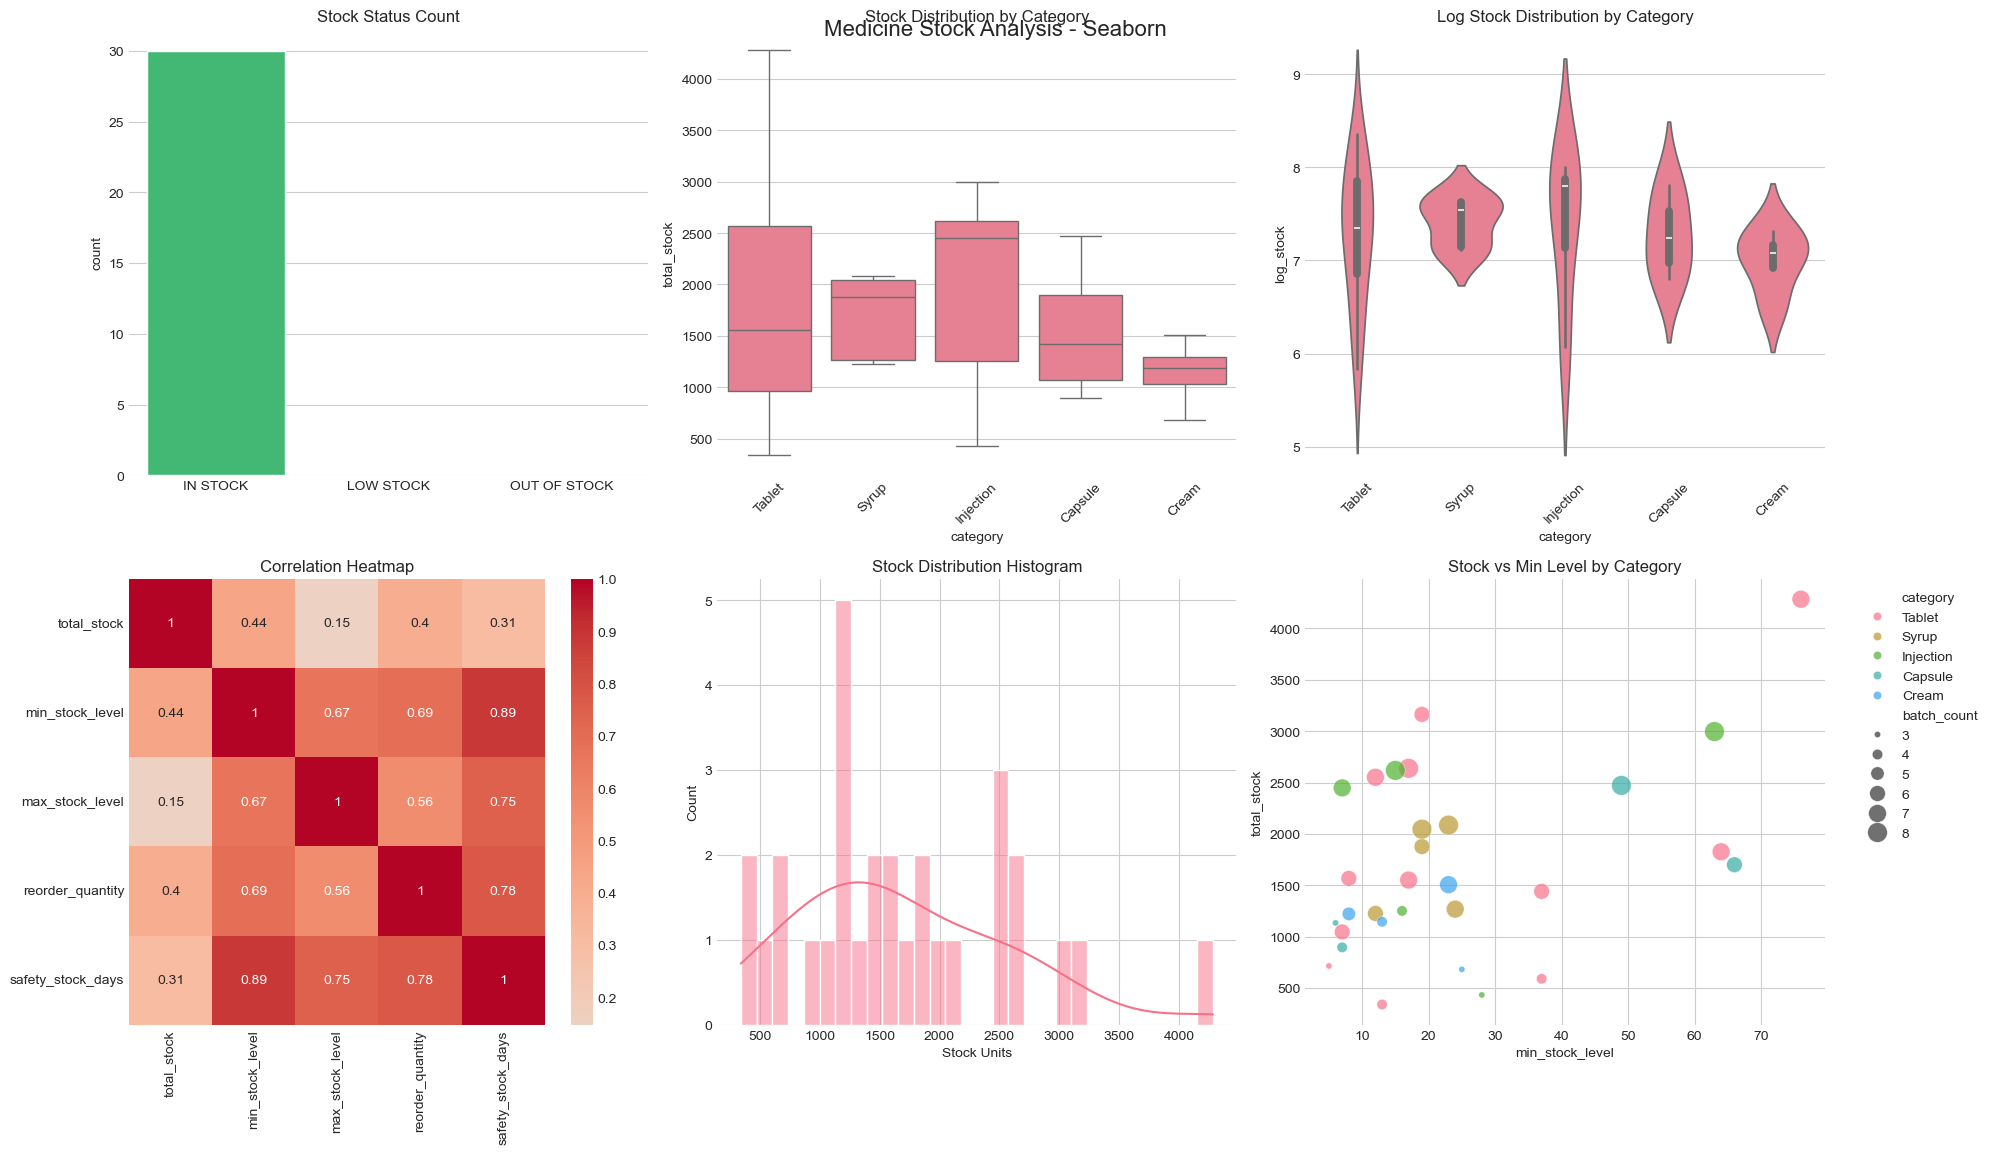

✅ Seaborn dashboard saved as 'medicine_dashboard_seaborn.png'


In [12]:
# =============================================
# CELL 6: Seaborn Visualizations
# =============================================

print("🎨 Creating Seaborn Visualizations...")

# Set seaborn style
sns.set_style("whitegrid")
sns.set_palette("husl")

# Create figure
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Medicine Stock Analysis - Seaborn', fontsize=16, y=0.95)

# 1. Count plot of stock status
ax1 = axes[0, 0]
sns.countplot(data=df_final, x='stock_status', 
              order=['IN STOCK', 'LOW STOCK', 'OUT OF STOCK'],
              palette=['#2ecc71', '#f1c40f', '#e74c3c'], ax=ax1)
ax1.set_title('Stock Status Count')
ax1.set_xlabel('')

# 2. Box plot of stock by category
ax2 = axes[0, 1]
sns.boxplot(data=df_final, x='category', y='total_stock', ax=ax2)
ax2.set_title('Stock Distribution by Category')
ax2.tick_params(axis='x', rotation=45)

# 3. Violin plot of stock (log scale)
ax3 = axes[0, 2]
df_log = df_final.copy()
df_log['log_stock'] = np.log1p(df_log['total_stock'])
sns.violinplot(data=df_log, x='category', y='log_stock', ax=ax3)
ax3.set_title('Log Stock Distribution by Category')
ax3.tick_params(axis='x', rotation=45)

# 4. Heatmap of correlation
ax4 = axes[1, 0]
numeric_cols = df_final[['total_stock', 'min_stock_level', 'max_stock_level', 
                         'reorder_quantity', 'safety_stock_days']].select_dtypes(include=[np.number])
corr_matrix = numeric_cols.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax4)
ax4.set_title('Correlation Heatmap')

# 5. Histogram of stock distribution
ax5 = axes[1, 1]
sns.histplot(data=df_final, x='total_stock', bins=30, kde=True, ax=ax5)
ax5.set_title('Stock Distribution Histogram')
ax5.set_xlabel('Stock Units')

# 6. Scatter plot with hue
ax6 = axes[1, 2]
sns.scatterplot(data=df_final, x='min_stock_level', y='total_stock', 
                hue='category', size='batch_count', sizes=(20, 200), alpha=0.7, ax=ax6)
ax6.set_title('Stock vs Min Level by Category')
ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('medicine_dashboard_seaborn.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Seaborn dashboard saved as 'medicine_dashboard_seaborn.png'")

📊 Creating Plotly Interactive Visualizations...


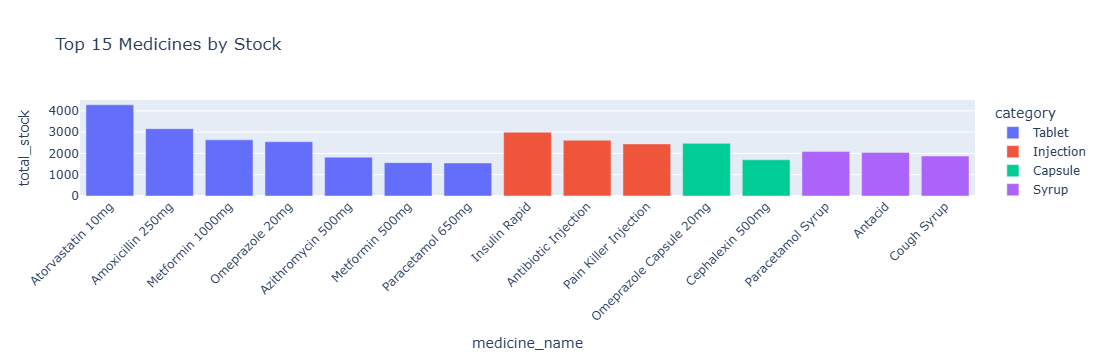

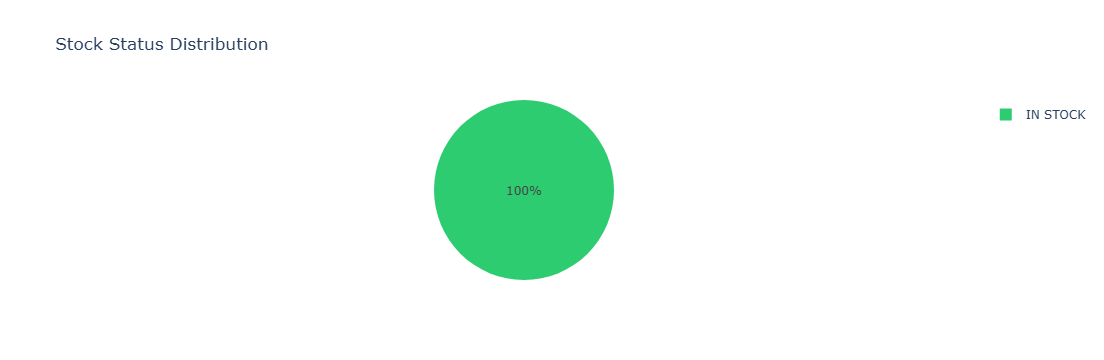

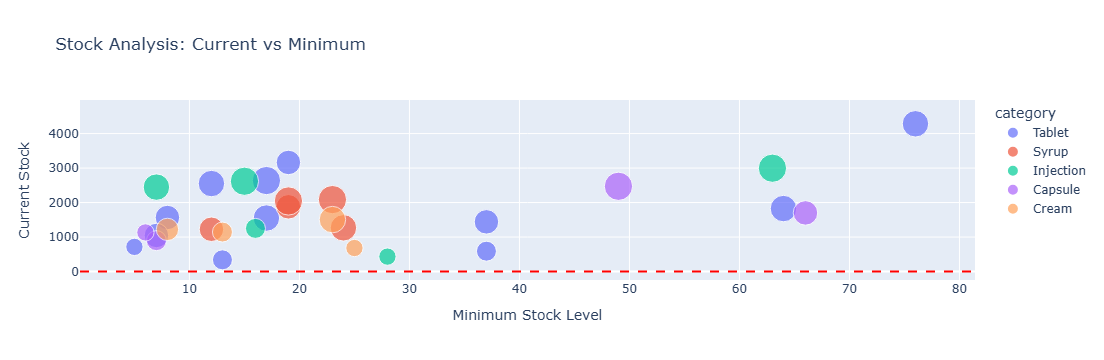

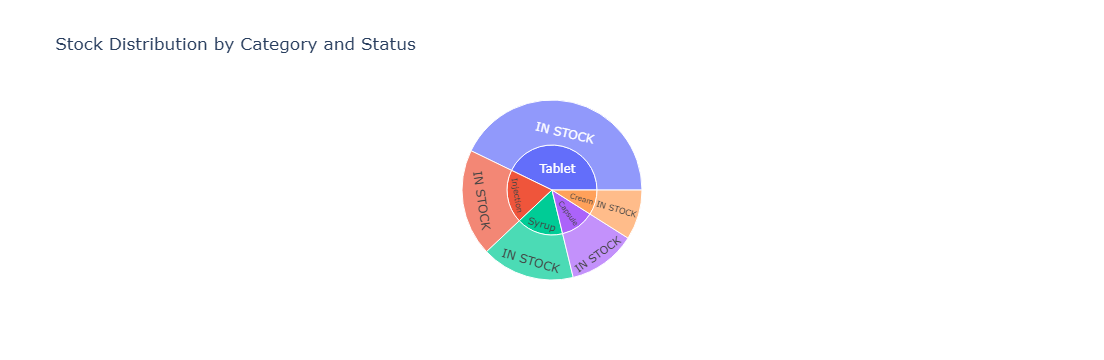

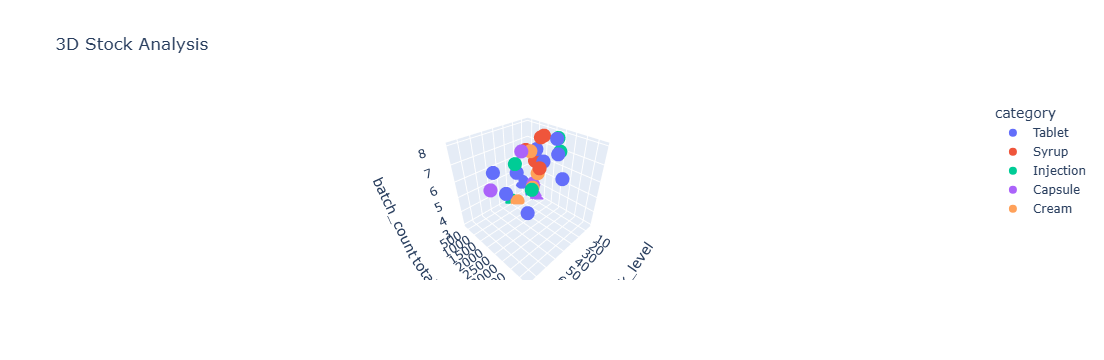

✅ Plotly visualizations created!


In [13]:
# =============================================
# CELL 7: Plotly Interactive Visualizations
# =============================================

print("📊 Creating Plotly Interactive Visualizations...")

# 1. Interactive Bar Chart - Stock by Medicine
fig1 = px.bar(df_final.nlargest(15, 'total_stock'), 
              x='medicine_name', 
              y='total_stock',
              color='category',
              title='Top 15 Medicines by Stock',
              hover_data=['min_stock_level', 'stock_status'])
fig1.update_layout(xaxis_tickangle=-45)
fig1.show()

# 2. Pie Chart - Stock Status
fig2 = px.pie(df_final, 
              names='stock_status', 
              values='total_stock',
              title='Stock Status Distribution',
              color='stock_status',
              color_discrete_map={'IN STOCK': '#2ecc71', 
                                 'LOW STOCK': '#f1c40f', 
                                 'OUT OF STOCK': '#e74c3c'})
fig2.show()

# 3. Scatter Plot - Stock Analysis
fig3 = px.scatter(df_final, 
                  x='min_stock_level', 
                  y='total_stock',
                  size='batch_count',
                  color='category',
                  hover_name='medicine_name',
                  title='Stock Analysis: Current vs Minimum',
                  labels={'min_stock_level': 'Minimum Stock Level', 
                         'total_stock': 'Current Stock'})
fig3.add_hline(y=0, line_dash="dash", line_color="red")
fig3.show()

# 4. Sunburst Chart - Category and Status
fig4 = px.sunburst(df_final, 
                   path=['category', 'stock_status'], 
                   values='total_stock',
                   title='Stock Distribution by Category and Status')
fig4.show()

# 5. 3D Scatter Plot
fig5 = px.scatter_3d(df_final, 
                     x='min_stock_level', 
                     y='total_stock', 
                     z='batch_count',
                     color='category',
                     hover_name='medicine_name',
                     title='3D Stock Analysis')
fig5.show()

print("✅ Plotly visualizations created!")

🏢 SUPPLIER PERFORMANCE ANALYSIS

1️⃣ SUPPLIER SUMMARY:
                 supplier  total_orders  total_units  current_stock  \
0  Emergency Meds Pvt Ltd            41        24353          14328   
1  Generic Medicines Corp            33        16914           9601   
2     HealthCare Supplies            30        15492           6316   
3   MediDistributors Ltd.            34        20469          11511   
4     PharmaWholesale Co.            38        19813           8962   

    avg_price  unique_medicines           supplier_name  lead_time_days  
0  263.294878                21  Emergency Meds Pvt Ltd               1  
1  278.509091                21  Generic Medicines Corp               4  
2  244.854000                17     HealthCare Supplies               2  
3  247.797647                23   MediDistributors Ltd.               3  
4  264.228684                21     PharmaWholesale Co.               5  


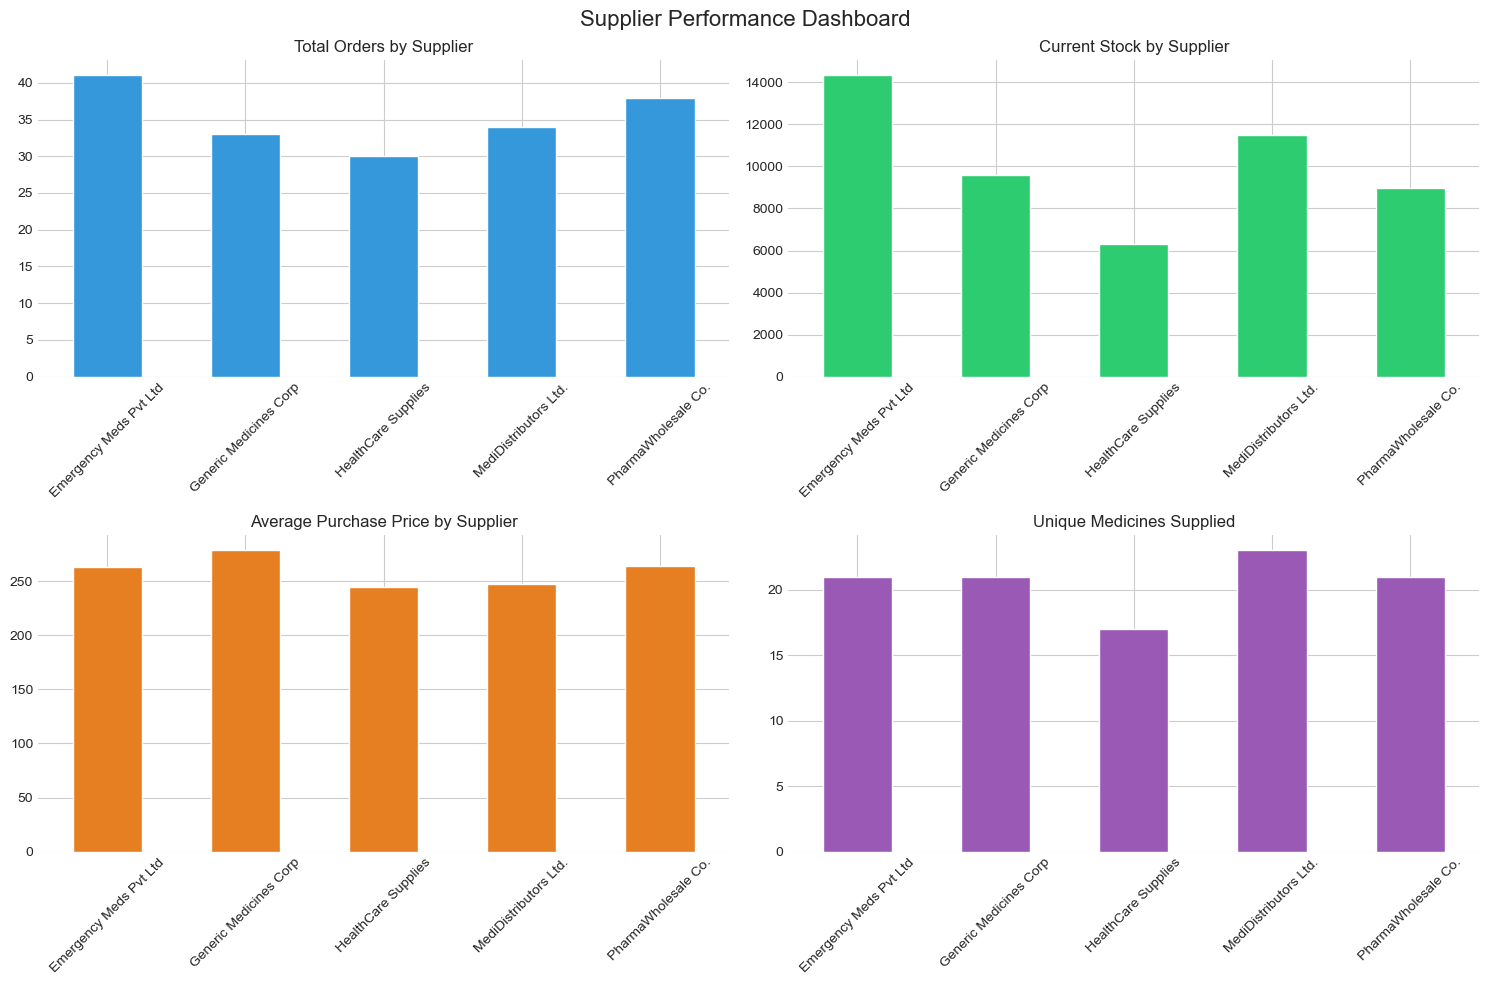

✅ Supplier analysis saved as 'supplier_performance.png'


In [15]:
# =============================================
# CELL 9: Supplier Performance Analysis
# =============================================

print("🏢 SUPPLIER PERFORMANCE ANALYSIS")
print("="*50)

# Merge purchases with suppliers
df_purchase_supplier = pd.merge(df_purchases, df_suppliers, on='supplier_id')

# Supplier summary
supplier_summary = df_purchase_supplier.groupby('supplier_name').agg({
    'purchase_id': 'count',
    'quantity_purchased': 'sum',
    'quantity_remaining': 'sum',
    'purchase_price': 'mean',
    'medicine_id': 'nunique'
}).reset_index()

supplier_summary.columns = ['supplier', 'total_orders', 'total_units', 
                           'current_stock', 'avg_price', 'unique_medicines']

# Add lead time
supplier_lead = df_suppliers[['supplier_name', 'lead_time_days']]
supplier_summary = pd.merge(supplier_summary, supplier_lead, left_on='supplier', right_on='supplier_name')

print("\n1️⃣ SUPPLIER SUMMARY:")
print(supplier_summary)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Supplier Performance Dashboard', fontsize=16)

# Orders by supplier
ax1 = axes[0, 0]
supplier_summary.set_index('supplier')['total_orders'].plot(kind='bar', ax=ax1, color='#3498db')
ax1.set_title('Total Orders by Supplier')
ax1.set_xlabel('')
ax1.tick_params(axis='x', rotation=45)

# Stock by supplier
ax2 = axes[0, 1]
supplier_summary.set_index('supplier')['current_stock'].plot(kind='bar', ax=ax2, color='#2ecc71')
ax2.set_title('Current Stock by Supplier')
ax2.set_xlabel('')
ax2.tick_params(axis='x', rotation=45)

# Avg price by supplier
ax3 = axes[1, 0]
supplier_summary.set_index('supplier')['avg_price'].plot(kind='bar', ax=ax3, color='#e67e22')
ax3.set_title('Average Purchase Price by Supplier')
ax3.set_xlabel('')
ax3.tick_params(axis='x', rotation=45)

# Unique medicines by supplier
ax4 = axes[1, 1]
supplier_summary.set_index('supplier')['unique_medicines'].plot(kind='bar', ax=ax4, color='#9b59b6')
ax4.set_title('Unique Medicines Supplied')
ax4.set_xlabel('')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('supplier_performance.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Supplier analysis saved as 'supplier_performance.png'")

💰 SALES ANALYSIS

1️⃣ DAILY SALES SUMMARY:
Total Sales Transactions: 8,929
Total Units Sold: 19,720
Average Daily Sales: 217
Max Daily Sales: 358

2️⃣ TOP 10 SELLING MEDICINES:
                 medicine  total_sold  transaction_count
11       Cephalexin 500mg         744                324
17    Insulin Long-acting         734                342
27      Paracetamol 650mg         719                319
7        Antifungal Cream         711                320
9       Atorvastatin 20mg         703                307
8       Atorvastatin 10mg         696                296
29  Vitamin B12 Injection         695                314
16        Ibuprofen Syrup         684                306
13       Cetirizine Syrup         675                307
1       Amoxicillin 250mg         669                299


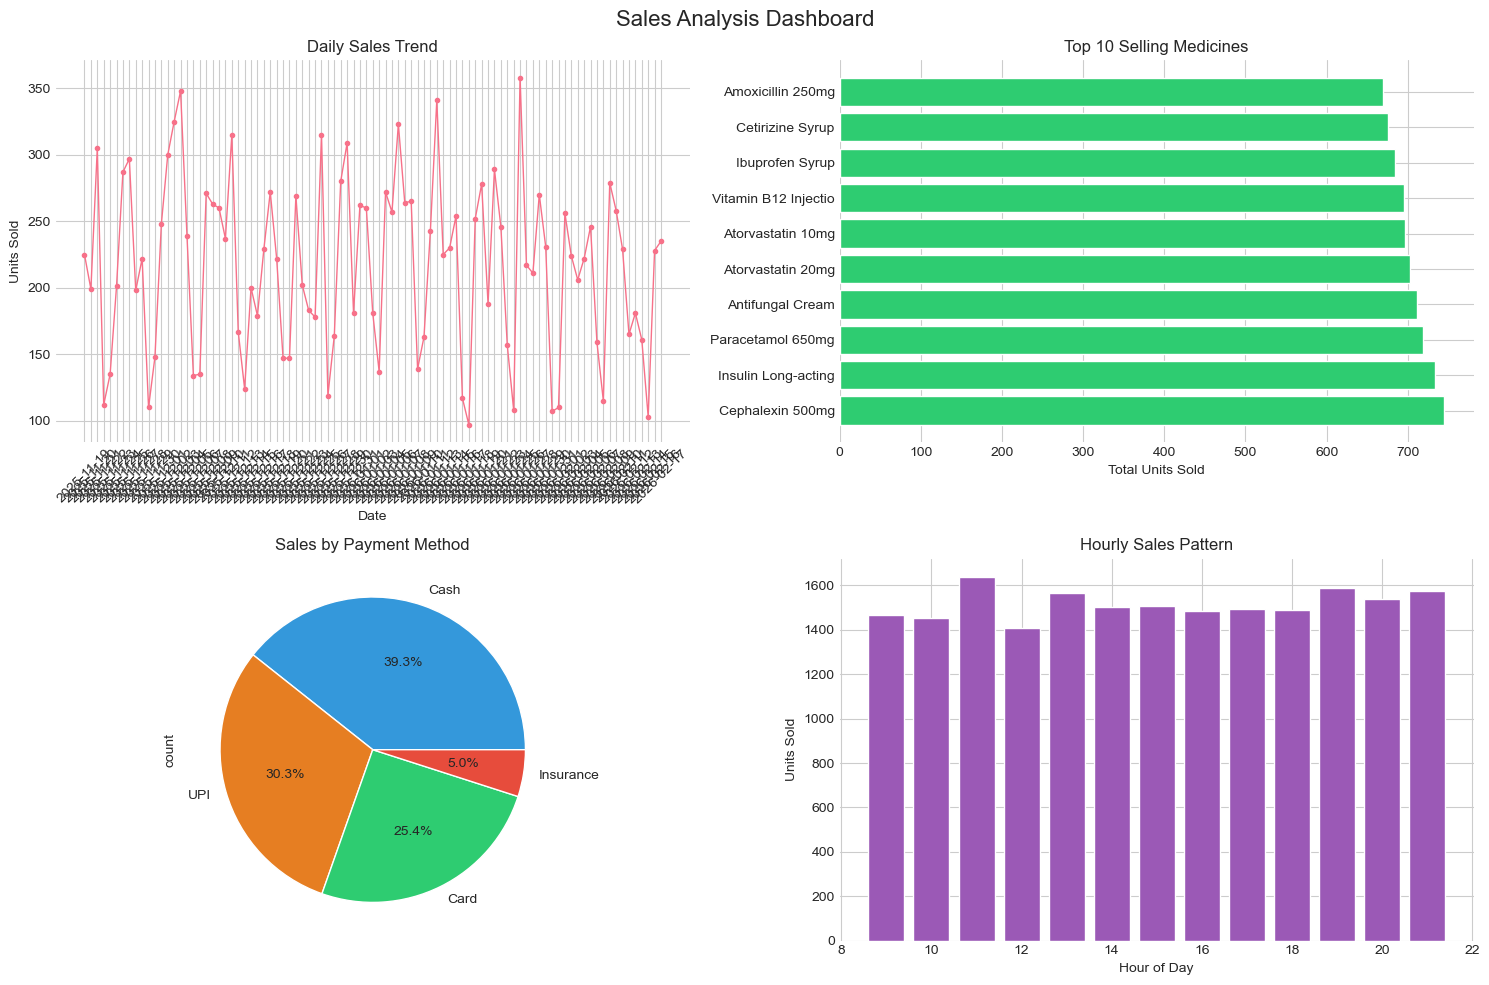

✅ Sales analysis saved as 'sales_analysis.png'


In [16]:
# =============================================
# CELL 10: Sales Analysis
# =============================================

print("💰 SALES ANALYSIS")
print("="*50)

# Merge sales with medicines
df_sales_merged = pd.merge(df_sales, df_medicines, on='medicine_id')

# Daily sales trend
daily_sales = df_sales.groupby('sale_date')['quantity_sold'].sum().reset_index()
daily_sales.columns = ['date', 'total_sold']

print("\n1️⃣ DAILY SALES SUMMARY:")
print(f"Total Sales Transactions: {len(df_sales):,}")
print(f"Total Units Sold: {df_sales['quantity_sold'].sum():,}")
print(f"Average Daily Sales: {daily_sales['total_sold'].mean():.0f}")
print(f"Max Daily Sales: {daily_sales['total_sold'].max()}")

# Top selling medicines
top_medicines = df_sales_merged.groupby('medicine_name').agg({
    'quantity_sold': 'sum',
    'sale_id': 'count'
}).reset_index()
top_medicines.columns = ['medicine', 'total_sold', 'transaction_count']
top_medicines = top_medicines.sort_values('total_sold', ascending=False).head(10)

print("\n2️⃣ TOP 10 SELLING MEDICINES:")
print(top_medicines)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Sales Analysis Dashboard', fontsize=16)

# Daily sales trend
ax1 = axes[0, 0]
ax1.plot(daily_sales['date'], daily_sales['total_sold'], marker='o', markersize=3, linewidth=1)
ax1.set_title('Daily Sales Trend')
ax1.set_xlabel('Date')
ax1.set_ylabel('Units Sold')
ax1.tick_params(axis='x', rotation=45)

# Top selling medicines
ax2 = axes[0, 1]
ax2.barh(top_medicines['medicine'].str[:20], top_medicines['total_sold'], color='#2ecc71')
ax2.set_title('Top 10 Selling Medicines')
ax2.set_xlabel('Total Units Sold')

# Sales by payment method
ax3 = axes[1, 0]
payment_sales = df_sales['payment_method'].value_counts()
colors_payment = ['#3498db', '#e67e22', '#2ecc71', '#e74c3c']
payment_sales.plot(kind='pie', ax=ax3, autopct='%1.1f%%', colors=colors_payment[:len(payment_sales)])
ax3.set_title('Sales by Payment Method')

# Hourly sales pattern
ax4 = axes[1, 1]
df_sales['hour'] = pd.to_datetime(df_sales['sale_time'], format='%H:%M').dt.hour
hourly_sales = df_sales.groupby('hour')['quantity_sold'].sum()
ax4.bar(hourly_sales.index, hourly_sales.values, color='#9b59b6')
ax4.set_title('Hourly Sales Pattern')
ax4.set_xlabel('Hour of Day')
ax4.set_ylabel('Units Sold')

plt.tight_layout()
plt.savefig('sales_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Sales analysis saved as 'sales_analysis.png'")

📊 Creating Comprehensive Dashboard...


NameError: name 'valid_stock' is not defined

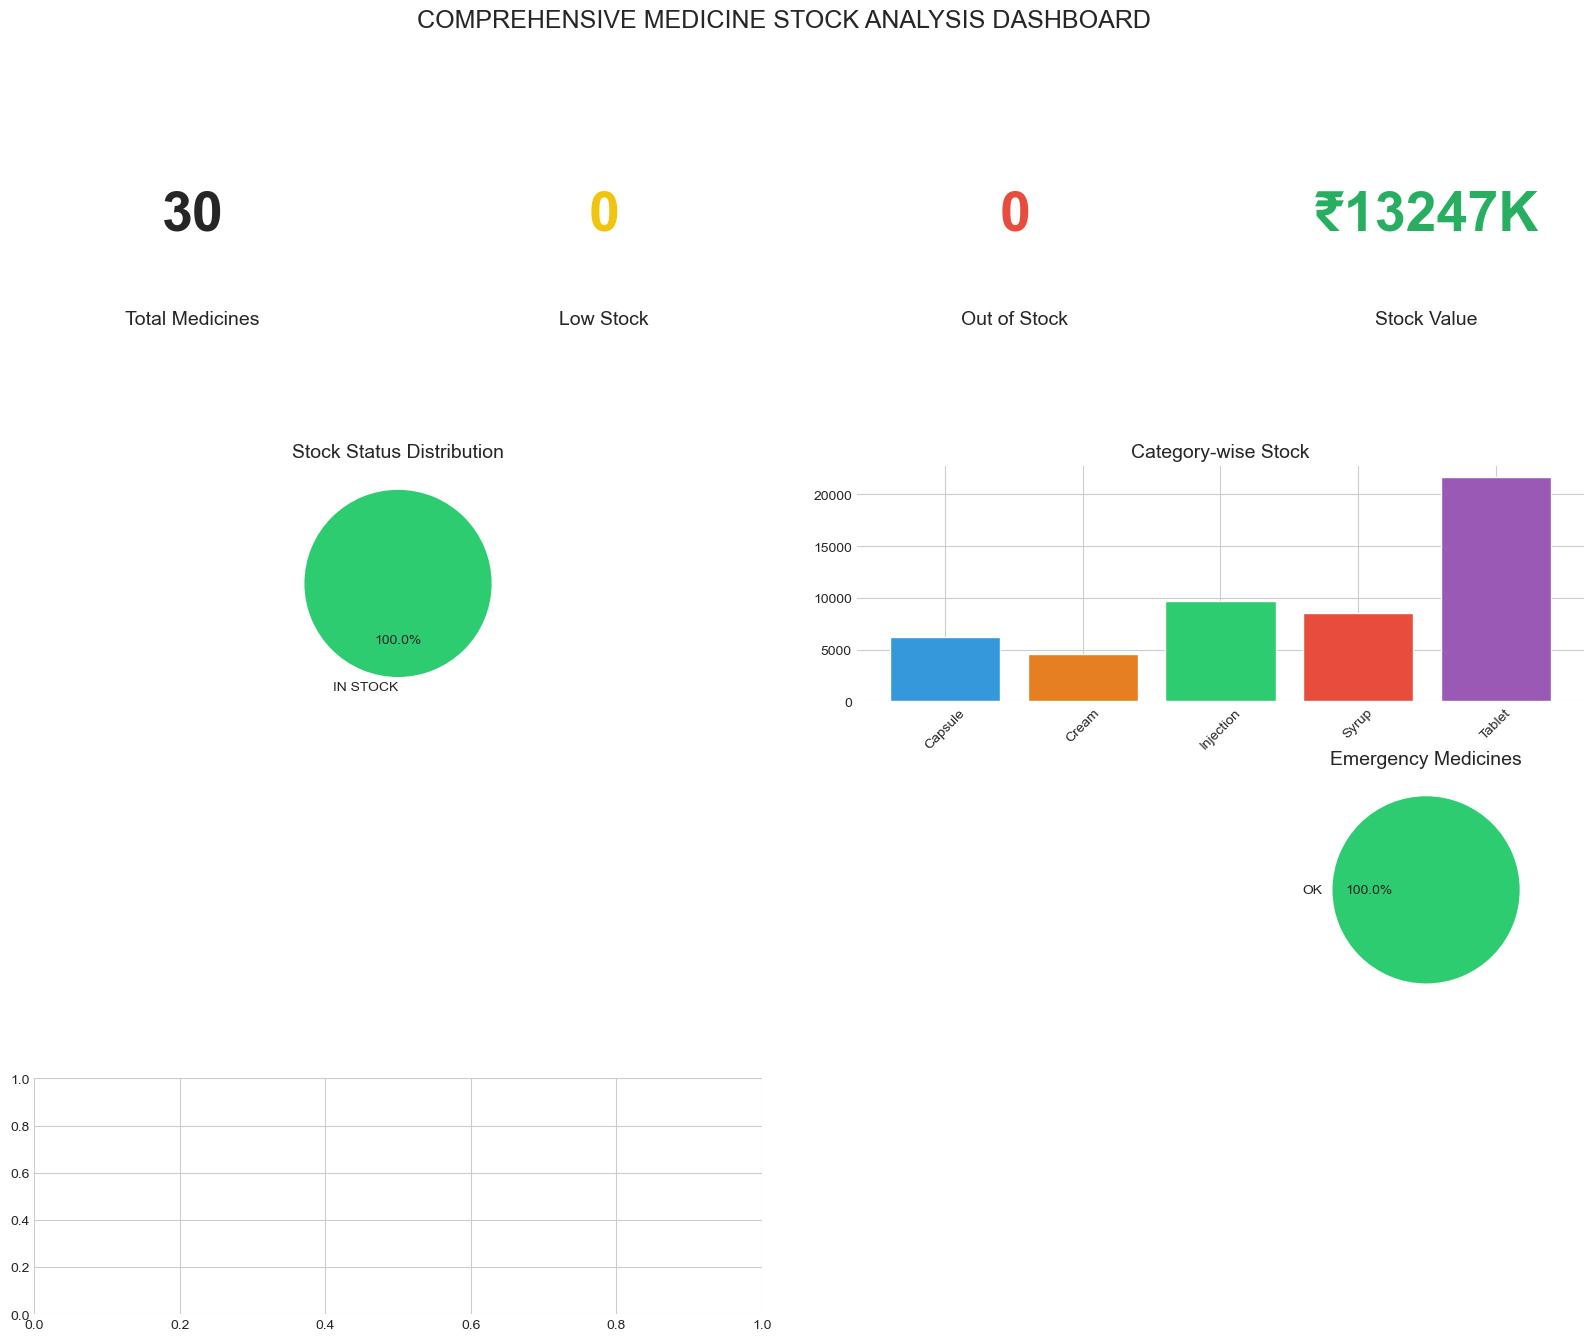

In [17]:
# =============================================
# CELL 11: Comprehensive Dashboard with Subplots
# =============================================

print("📊 Creating Comprehensive Dashboard...")

fig = plt.figure(figsize=(20, 15))
fig.suptitle('COMPREHENSIVE MEDICINE STOCK ANALYSIS DASHBOARD', fontsize=18, y=0.98)

# Grid layout
gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

# Row 1: Key Metrics Cards
ax1 = fig.add_subplot(gs[0, 0])
ax1.axis('off')
ax1.text(0.5, 0.7, f"{len(df_final)}", fontsize=40, ha='center', fontweight='bold')
ax1.text(0.5, 0.3, "Total Medicines", fontsize=14, ha='center')

ax2 = fig.add_subplot(gs[0, 1])
ax2.axis('off')
low_count = len(df_final[df_final['stock_status'] == 'LOW STOCK'])
ax2.text(0.5, 0.7, f"{low_count}", fontsize=40, ha='center', color='#f1c40f', fontweight='bold')
ax2.text(0.5, 0.3, "Low Stock", fontsize=14, ha='center')

ax3 = fig.add_subplot(gs[0, 2])
ax3.axis('off')
out_count = len(df_final[df_final['stock_status'] == 'OUT OF STOCK'])
ax3.text(0.5, 0.7, f"{out_count}", fontsize=40, ha='center', color='#e74c3c', fontweight='bold')
ax3.text(0.5, 0.3, "Out of Stock", fontsize=14, ha='center')

ax4 = fig.add_subplot(gs[0, 3])
ax4.axis('off')
total_value = (df_purchases['quantity_remaining'] * df_purchases['purchase_price']).sum()
ax4.text(0.5, 0.7, f"₹{total_value/1000:.0f}K", fontsize=40, ha='center', color='#27ae60', fontweight='bold')
ax4.text(0.5, 0.3, "Stock Value", fontsize=14, ha='center')

# Row 2: Stock Status and Category
ax5 = fig.add_subplot(gs[1, 0:2])
status_counts = df_final['stock_status'].value_counts()
colors_status = ['#2ecc71', '#f1c40f', '#e74c3c']
ax5.pie(status_counts.values, labels=status_counts.index, colors=colors_status, 
        autopct='%1.1f%%', startangle=90)
ax5.set_title('Stock Status Distribution', fontsize=14)

ax6 = fig.add_subplot(gs[1, 2:4])
category_stock = df_final.groupby('category')['total_stock'].sum()
ax6.bar(category_stock.index, category_stock.values, color=['#3498db', '#e67e22', '#2ecc71', '#e74c3c', '#9b59b6'])
ax6.set_title('Category-wise Stock', fontsize=14)
ax6.tick_params(axis='x', rotation=45)

# Row 3: Low Stock Table and Emergency
ax7 = fig.add_subplot(gs[2, 0:3])
ax7.axis('off')
low_stock_items = df_final[df_final['stock_status'] == 'LOW STOCK'].nlargest(5, 'total_stock')
if len(low_stock_items) > 0:
    table_data = low_stock_items[['medicine_name', 'total_stock', 'min_stock_level']].values
    columns = ['Medicine', 'Stock', 'Min Required']
    table = ax7.table(cellText=table_data, colLabels=columns, 
                      cellLoc='left', loc='center', colWidths=[0.3, 0.15, 0.15])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    for (i, j), cell in table.get_celld().items():
        if i == 0:
            cell.set_facecolor('#34495e')
            cell.set_text_props(color='white', fontweight='bold')
    ax7.set_title('Top 5 Low Stock Items', fontsize=14, y=1.1)

ax8 = fig.add_subplot(gs[2, 3])
emergency_data = df_final[df_final['is_emergency'] == 1]
emergency_counts = emergency_data['emergency_status'].value_counts()
if not emergency_counts.empty:
    colors_emergency = {'OK': '#2ecc71', 'LOW': '#e74c3c'}
    emergency_colors = [colors_emergency.get(x, '#95a5a6') for x in emergency_counts.index]
    ax8.pie(emergency_counts.values, labels=emergency_counts.index, 
            colors=emergency_colors, autopct='%1.1f%%')
    ax8.set_title('Emergency Medicines', fontsize=14)

# Row 4: Expiry and Sales
ax9 = fig.add_subplot(gs[3, 0:2])
expiry_counts = valid_stock['expiry_category'].value_counts().sort_index()
if not expiry_counts.empty:
    expiry_counts.plot(kind='bar', ax=ax9, color=['#e74c3c', '#e67e22', '#f1c40f', '#2ecc71', '#3498db'])
    ax9.set_title('Expiry Timeline', fontsize=14)
    ax9.set_xlabel('Days to Expiry')
    ax9.set_ylabel('Batches')
    ax9.tick_params(axis='x', rotation=45)

ax10 = fig.add_subplot(gs[3, 2:4])
if not daily_sales.empty:
    ax10.plot(daily_sales['date'].tail(30), daily_sales['total_sold'].tail(30), 
              marker='o', markersize=4, linewidth=2, color='#e74c3c')
    ax10.set_title('Last 30 Days Sales Trend', fontsize=14)
    ax10.set_xlabel('Date')
    ax10.set_ylabel('Units Sold')
    ax10.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('comprehensive_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Comprehensive dashboard saved as 'comprehensive_dashboard.png'")